In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SVMSMOTE

from datetime import datetime
from pprint import pprint

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Credit Risk Score Prediction on Aave Protocol v2

*Disclaimer: this effort is made with limited knowledge on aave governance, and hence some assumptions are addressed as necessary.*

## 1. Exploratory and Analysis

The v2 protocol is chosen as it contains more recent data. On the other hand, the v1 protocol shows deposit history for the year 2020 for some reason. Based on the requirement, we query 100 addresses of `user` data together with their respective `unclaimedRewards`, `lifetimeRewards`, `incentivizedActions`, last 100 addresses of the `depositHistory`, `borrowHistory`, `repayHistory`, and `redeemUnderlyingHistory`.

In [2]:
def run_query(query):
    """
    GraphQL query for Aave v2 protocol
    """
    # endpoint for making the request
    # https://api.thegraph.com/subgraphs/name/aave/protocol
    # https://api.thegraph.com/subgraphs/name/aave/protocol-multy-raw
    request = requests.post('https://api.thegraph.com/subgraphs/name/aave/protocol-v2'
                            '',
                            json={'query': query})
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception('Query failed. return code is {}.      {}'.format(request.status_code, query))

In [3]:
users_query = """
{
  users(where: {
    id_not_in: ["0x0000000000000000000000000000000000000001",
                "0x000000000000000000000000000000000000dead"]
  }){
    id
    unclaimedRewards
    lifetimeRewards
    depositHistory(orderBy: timestamp, orderDirection: desc,) {
      id
      amount
      timestamp
      reserve {
        symbol
        name
        price{
          priceInEth
        }
        liquidityRate
        variableBorrowRate
        stableBorrowRate
      }
    }
    borrowHistory(orderBy: timestamp, orderDirection: desc) {
      id
      amount
      timestamp
      reserve {
        symbol
        name
        price{
          priceInEth
        }
        liquidityRate
        variableBorrowRate
        stableBorrowRate
      }
      borrowRate
      borrowRateMode
      stableTokenDebt
      variableTokenDebt
    }
    repayHistory(orderBy: timestamp, orderDirection: desc){
      id
      amount
      timestamp
      reserve{
        symbol
        name
        price{
          priceInEth
        }
        liquidityRate
        variableBorrowRate
        stableBorrowRate
      }
    }
    redeemUnderlyingHistory(orderBy: timestamp, orderDirection: desc){
      id
      amount
      timestamp
      reserve{
        symbol
        name
        price{
          priceInEth
        }
        liquidityRate
        variableBorrowRate
        stableBorrowRate
      }
    }
    incentivizedActions{
      id
      amount
    }
  }
}
"""


In [4]:
users_result = run_query(users_query)
#pprint(user_result)
#users_result['data']['users']

In [5]:
def extract_deposit_history(user_id, deposit=None):
    """
    Extract deposit history from a given user
    """
        
    deposit_dict = dict(
        user_id = user_id,
        deposit_reserve_name = '',
        deposit_reserve_symbol = '',
        deposit_reserve_priceInEth = 0,
        deposit_reserve_liquidityRate = 0,
        deposit_reserve_variableBorrowRate = 0,
        deposit_reserve_stableBorrowRate = 0,
        deposit_amount = 0,
        deposit_timestamp_unix = None,
        deposit_timestamp = None
    )
    
    if deposit:
        deposit_dict['deposit_reserve_name'] = deposit['reserve']['name']
        deposit_dict['deposit_reserve_symbol'] = deposit['reserve']['symbol']
        deposit_dict['deposit_reserve_priceInEth'] = int(deposit['reserve']['price']['priceInEth'])
        deposit_dict['deposit_reserve_liquidityRate'] = int(deposit['reserve']['liquidityRate'])
        deposit_dict['deposit_reserve_variableBorrowRate'] = int(deposit['reserve']['variableBorrowRate'])
        deposit_dict['deposit_reserve_stableBorrowRate'] = int(deposit['reserve']['stableBorrowRate'])
        deposit_dict['deposit_amount'] = int(deposit['amount'])
        deposit_dict['deposit_timestamp_unix'] = deposit['timestamp']
        deposit_dict['deposit_timestamp'] = pd.to_datetime(deposit['timestamp'], 
                                                           unit='s', errors='ignore')
        
    return deposit_dict

def extract_borrow_history(user_id, borrow=None):
    """
    Extract borrow history from a given user
    """
    
    borrow_dict = dict(
        user_id = user_id,
        borrow_reserve_name = '',
        borrow_reserve_symbol = '',
        borrow_reserve_priceInEth = 0,
        borrow_reserve_liquidityRate = 0,
        borrow_reserve_variableBorrowRate = 0,
        borrow_reserve_stableBorrowRate = 0,
        borrow_amount = 0,
        borrow_timestamp_unix = None,
        borrow_timestamp = None,
        borrow_rate = 0,
        borrow_rate_mode = '',
        borrow_stableTokenDebt = 0,
        borrow_variableTokenDebt = 0
        #borrow_accrued_interest = 0
    )
    
    if borrow:
        borrow_dict['borrow_reserve_name'] = borrow['reserve']['name']
        borrow_dict['borrow_reserve_symbol'] = borrow['reserve']['symbol']
        borrow_dict['borrow_reserve_priceInEth'] = int(borrow['reserve']['price']['priceInEth'])
        borrow_dict['borrow_reserve_liquidityRate'] = int(borrow['reserve']['liquidityRate'])
        borrow_dict['borrow_reserve_variableBorrowRate'] = int(borrow['reserve']['variableBorrowRate'])
        borrow_dict['borrow_reserve_stableBorrowRate'] = int(borrow['reserve']['stableBorrowRate'])
        borrow_dict['borrow_amount'] = int(borrow['amount'])
        borrow_dict['borrow_timestamp_unix'] = borrow['timestamp']
        borrow_dict['borrow_timestamp'] = pd.to_datetime(borrow['timestamp'],
                                                         unit='s', errors='ignore')
        borrow_dict['borrow_rate'] = int(borrow['borrowRate'])
        borrow_dict['borrow_rate_mode'] = borrow['borrowRateMode']
        borrow_dict['borrow_stableTokenDebt'] = int(borrow['stableTokenDebt'])
        borrow_dict['borrow_variableTokenDebt'] = int(borrow['variableTokenDebt'])
        #borrow_dict['borrow_accrued_interest'] = int(borrow['accruedBorrowInterest'])
    
    return borrow_dict

def extract_repay_history(user_id, repay=None):
    """
    Extract repay history from a given user
    """
    
    repay_dict = dict(
        user_id = user_id,
        repay_reserve_name = '',
        repay_reserve_symbol = '',
        repay_reserve_priceInEth = 0,
        repay_reserve_liquidityRate = 0,
        repay_reserve_variableBorrowRate = 0,
        repay_reserve_stableBorrowRate = 0,
        repay_amount = 0,
        repay_timestamp_unix = None,
        repay_timestamp = None
    )
    
    if repay:
        repay_dict['repay_reserve_name'] = repay['reserve']['name']
        repay_dict['repay_reserve_symbol'] = repay['reserve']['symbol']
        repay_dict['repay_reserve_priceInEth'] = int(repay['reserve']['price']['priceInEth'])
        repay_dict['repay_reserve_liquidityRate'] = int(repay['reserve']['liquidityRate'])
        repay_dict['repay_reserve_variableBorrowRate'] = int(repay['reserve']['variableBorrowRate'])
        repay_dict['repay_reserve_stableBorrowRate'] = int(repay['reserve']['stableBorrowRate'])
        repay_dict['repay_amount'] = int(repay['amount'])
        repay_dict['repay_timestamp_unix'] = repay['timestamp']
        repay_dict['repay_timestamp'] = pd.to_datetime(repay['timestamp'],
                                                       unit='s', errors='ignore')

    return repay_dict


def extract_redeemUnderlying_history(user_id, redeem=None):
    """
    Extract redeem underlying history from a given user
    """
    
    redeem_dict = dict(
        user_id = user_id,
        redeem_reserve_name = '',
        redeem_reserve_symbol = '',
        redeem_reserve_priceInEth = 0,
        redeem_reserve_liquidityRate = 0,
        redeem_reserve_variableBorrowRate = 0,
        redeem_reserve_stableBorrowRate = 0,
        redeem_amount = 0,
        redeem_timestamp_unix = None,
        redeem_timestamp = None
    )
    
    if redeem:
        redeem_dict['redeem_reserve_name'] = redeem['reserve']['name']
        redeem_dict['redeem_reserve_symbol'] = redeem['reserve']['symbol']
        redeem_dict['redeem_reserve_priceInEth'] = int(redeem['reserve']['price']['priceInEth'])
        redeem_dict['redeem_reserve_liquidityRate'] = int(redeem['reserve']['liquidityRate'])
        redeem_dict['redeem_reserve_variableBorrowRate'] = int(redeem['reserve']['variableBorrowRate'])
        redeem_dict['redeem_reserve_stableBorrowRate'] = int(redeem['reserve']['stableBorrowRate'])
        redeem_dict['redeem_amount'] = int(redeem['amount'])
        redeem_dict['redeem_timestamp_unix'] = int(redeem['timestamp'])
        redeem_dict['redeem_timestamp'] = pd.to_datetime(redeem['timestamp'],
                                                         unit='s', errors='ignore')

    return redeem_dict
    



In [6]:
users, deposits, borrows, repays, redeems = [], [], [], [], []
for user in users_result['data']['users']:
    #print(user, '\n')
    
    user_id = user['id']
        
    users.append(dict(
        user_id = user_id,
        user_unclaimedRewards = int(user['unclaimedRewards']),
        user_lifetimeRewards = int(user['lifetimeRewards']),
        user_incentivizedActions = int(user['incentivizedActions'][0]['amount']) \
            if user['incentivizedActions'] else 0
    ))
    
    # extract depositHistory
    if user['depositHistory']:
        for deposit in user['depositHistory']:
            deposit_dict = extract_deposit_history(user_id, deposit)
            deposits.append(deposit_dict)
    else:
        deposit_dict = extract_deposit_history(user_id)
        deposits.append(deposit_dict)
    
    # extract borrowHistory
    if user['borrowHistory']:
        for borrow in user['borrowHistory']:
            borrow_dict = extract_borrow_history(user_id, borrow)
            borrows.append(borrow_dict)
    else:
        borrow_dict = extract_borrow_history(user_id)
        borrows.append(borrow_dict)
   
    # extract repayHistory
    if user['repayHistory']:
        for repay in  user['repayHistory']:
            repay_dict = extract_repay_history(user_id, repay)
            repays.append(repay_dict)
    else:
        repay_dict = extract_repay_history(user_id)
        repays.append(repay_dict)
        
    # extract redeemUnderlyingHistory
    if user['redeemUnderlyingHistory']:
        for redeem in user['redeemUnderlyingHistory']:
            redeem_dict = extract_redeemUnderlying_history(user_id, redeem)
            redeems.append(redeem_dict)
    else:
        redeem_dict = extract_redeemUnderlying_history(user_id)
        redeems.append(redeem_dict)
            

In [7]:
users_df = pd.DataFrame(users).astype({
    'user_unclaimedRewards': 'float64',
    'user_lifetimeRewards': 'float64',
    'user_incentivizedActions': 'float64'
})
users_df.head()

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions
0,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,4.600000e+01,4.600000e+01,4.000000e+00
1,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,7.217727e+15,7.217727e+15,2.964439e+15
2,0x00000000005dbcb0d0513fcda746382fe8a53468,0.000000e+00,0.000000e+00,0.000000e+00
3,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.000000e+00,0.000000e+00,0.000000e+00
4,0x0000000000d41c96294ccdac8612bdfe29c641af,0.000000e+00,0.000000e+00,0.000000e+00


### 1.1. No. of user with no rewards / incentivized actions and deposits / borrows

In [8]:

print(f'no unclaimed rewards: {len(users_df[users_df.user_unclaimedRewards == 0])}')
print(f'no lifetime rewards: {len(users_df[users_df.user_lifetimeRewards == 0])}')
print(f'no incentivized actions: {len(users_df[users_df.user_incentivizedActions == 0])}')


no unclaimed rewards: 69
no lifetime rewards: 63
no incentivized actions: 63


Out of 100 users, there are 6 users with lifetime rewards and incentivized actions but do not have unclaimed rewards. And there are 2 users that have not claimed all the lifetime rewards.

In [9]:
users_df[users_df.user_unclaimedRewards != users_df.user_lifetimeRewards]

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions
40,0x00137878c7c179cad13505c18c86fd84623f04c7,0.000000e+00,1.643452e+18,5.149035e+08
42,0x0013eb108d5168bf2285f0f54172394f7c17d17d,0.000000e+00,7.243024e+18,7.243024e+18
43,0x0014a4f88a92d3924a3f553dc51c290ce06ae125,4.519764e+16,1.334680e+19,3.866509e+18
58,0x002ad2406d6d05e0c58e39af6eb506f762e9f7bb,0.000000e+00,2.954459e+18,3.784487e+17
64,0x0032311e56bc34efde20b408bb99d986eea1863a,8.852672e+16,4.770834e+17,1.388911e+16
80,0x00405dc6b34d782df3feb0f0ec308fc27d4bd6bb,0.000000e+00,3.802339e+18,7.052461e+17
90,0x004c350cd1ab72ea28cd6c47935b5bb31f64a928,0.000000e+00,1.305511e+18,6.943395e+17
92,0x004f137c71b3003c7915bd6aa3a4f57e334a738e,0.000000e+00,2.907850e+17,7.974066e+16


In [10]:
deposits_df = pd.DataFrame(deposits).astype({
    'deposit_reserve_priceInEth': 'float64',
    'deposit_reserve_liquidityRate': 'float64',
    'deposit_reserve_variableBorrowRate': 'float64',
    'deposit_reserve_stableBorrowRate': 'float64',
    'deposit_amount': 'float64'
})
deposits_df.head()

,user_id,deposit_reserve_name,deposit_reserve_symbol,deposit_reserve_priceInEth,deposit_reserve_liquidityRate,deposit_reserve_variableBorrowRate,deposit_reserve_stableBorrowRate,deposit_amount,deposit_timestamp_unix,deposit_timestamp
0,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.755104e+23,5.974727e+24,3.746841e+25,1.270902e+17,1.626330e+09,2021-07-15 06:18:08
1,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.755104e+23,5.974727e+24,3.746841e+25,1.156952e+17,1.626201e+09,2021-07-13 18:30:44
2,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.755104e+23,5.974727e+24,3.746841e+25,1.150193e+17,1.626196e+09,2021-07-13 17:00:22
3,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.755104e+23,5.974727e+24,3.746841e+25,1.321669e+17,1.626074e+09,2021-07-12 07:16:40
4,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.755104e+23,5.974727e+24,3.746841e+25,1.145805e+17,1.625835e+09,2021-07-09 12:50:26


In [11]:
borrows_df = pd.DataFrame(borrows).astype({
    'borrow_reserve_priceInEth': 'float64',
    'borrow_reserve_liquidityRate': 'float64',
    'borrow_reserve_variableBorrowRate' : 'float64',
    'borrow_amount': 'float64',
    'borrow_rate': 'float64',
    'borrow_stableTokenDebt': 'float64',
    'borrow_variableTokenDebt': 'float64'
})
borrows_df.head()

,user_id,borrow_reserve_name,borrow_reserve_symbol,borrow_reserve_priceInEth,borrow_reserve_liquidityRate,borrow_reserve_variableBorrowRate,borrow_reserve_stableBorrowRate,borrow_amount,borrow_timestamp_unix,borrow_timestamp,borrow_rate,borrow_rate_mode,borrow_stableTokenDebt,borrow_variableTokenDebt
0,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,,,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,NaN,NaT,0.000000e+00,,0.0,0.000000e+00
1,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,Synthetix Network Token,SNX,3.228050e+15,4.247006e+25,1.151288e+26,0,5.000000e+21,1.622545e+09,2021-06-01 11:00:43,1.273128e+26,Variable,0.0,4.760354e+21
2,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,Republic Token,REN,1.433900e+14,9.321946e+23,1.386002e+25,19800033947311781925839668,1.000000e+23,1.622303e+09,2021-05-29 15:35:30,8.024004e+24,Variable,0.0,9.874062e+22
3,0x00000000005dbcb0d0513fcda746382fe8a53468,,,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,NaN,NaT,0.000000e+00,,0.0,0.000000e+00
4,0x00000000009a41862f3b2b0c688b7c0d1940511e,,,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00,NaN,NaT,0.000000e+00,,0.0,0.000000e+00


Observing the deposit and borrow history from the dataset, there are 23 users with no past deposit, 69 users with no past borrow, and 16 users with no past deposit and borrow. Therefore, we will purge these 16 users from the dataset.

In [12]:
no_deposits = set(deposits_df[deposits_df.deposit_amount == 0].user_id)
no_borrows = set(borrows_df[borrows_df.borrow_amount == 0].user_id)

print(f'no deposits: {len(no_deposits)}')
print(f'no borrows: {len(no_borrows)}')

no_transactions = list(no_deposits.intersection(no_borrows))
print(f'no transactions: {len(no_transactions)}') 


no deposits: 23
no borrows: 69
no transactions: 16


In [13]:
# drop user, deposit, and borrow with no transaction
users_df.drop(users_df[users_df.user_id.isin(no_transactions)].index, inplace=True)
deposits_df.drop(deposits_df[deposits_df.user_id.isin(no_transactions)].index, inplace=True)
borrows_df.drop(borrows_df[borrows_df.user_id.isin(no_transactions)].index, inplace=True)

In [14]:
repays_df = pd.DataFrame(repays).astype({
    'repay_reserve_priceInEth': 'float64',
    'repay_reserve_liquidityRate': 'float64',
    'repay_reserve_variableBorrowRate': 'float64',
    'repay_reserve_stableBorrowRate': 'float64',
    'repay_amount': 'float64'    
})
repays_df.head()

,user_id,repay_reserve_name,repay_reserve_symbol,repay_reserve_priceInEth,repay_reserve_liquidityRate,repay_reserve_variableBorrowRate,repay_reserve_stableBorrowRate,repay_amount,repay_timestamp_unix,repay_timestamp
0,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,,,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaT
1,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,Synthetix Network Token,SNX,3.228050e+15,4.247006e+25,1.151288e+26,0.000000e+00,5.000478e+21,1.622568e+09,2021-06-01 17:21:43
2,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,Republic Token,REN,1.433900e+14,9.321946e+23,1.386002e+25,1.980003e+25,1.000008e+23,1.622335e+09,2021-05-30 00:42:31
3,0x00000000005dbcb0d0513fcda746382fe8a53468,,,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaT
4,0x00000000009a41862f3b2b0c688b7c0d1940511e,,,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaT


In [15]:
redeems_df = pd.DataFrame(redeems).astype({
    'redeem_reserve_priceInEth': 'float64',
    'redeem_reserve_liquidityRate': 'float64',
    'redeem_reserve_variableBorrowRate': 'float64',
    'redeem_reserve_stableBorrowRate': 'float64',
    'redeem_amount': 'float64'
})
redeems_df.head()

,user_id,redeem_reserve_name,redeem_reserve_symbol,redeem_reserve_priceInEth,redeem_reserve_liquidityRate,redeem_reserve_variableBorrowRate,redeem_reserve_stableBorrowRate,redeem_amount,redeem_timestamp_unix,redeem_timestamp
0,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.755104e+23,5.974727e+24,3.746841e+25,1.317387e+17,1.626760e+09,2021-07-20 05:48:47
1,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.755104e+23,5.974727e+24,3.746841e+25,1.259542e+17,1.626443e+09,2021-07-16 13:45:12
2,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.755104e+23,5.974727e+24,3.746841e+25,9.442046e+16,1.624069e+09,2021-06-19 02:21:09
3,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.755104e+23,5.974727e+24,3.746841e+25,8.139624e+16,1.623842e+09,2021-06-16 11:12:51
4,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,Wrapped Ether,WETH,1.000000e+18,2.755104e+23,5.974727e+24,3.746841e+25,1.734259e+17,1.621815e+09,2021-05-24 00:03:22


Similarly, we want to drop the users with no past deposit and borrow from the repay and redeem history

In [16]:
repays_df.drop(repays_df[repays_df.user_id.isin(no_transactions)].index, inplace=True)
redeems_df.drop(redeems_df[redeems_df.user_id.isin(no_transactions)].index, inplace=True)

### 1.2. Standardizing the timestamp range

In [17]:
print(f'deposit timestamp range: {deposits_df.deposit_timestamp.min()} - {deposits_df.deposit_timestamp.max()}')
print(f'borrow timestamp range: {borrows_df.borrow_timestamp.min()} - {borrows_df.borrow_timestamp.max()}')
print(f'repay timestamp range: {repays_df.repay_timestamp.min()} - {repays_df.repay_timestamp.max()}')
print(f'redeem timestamp range: {redeems_df.redeem_timestamp.min()} - {redeems_df.redeem_timestamp.max()}')

deposit timestamp range: 2020-12-05 06:51:40 - 2021-08-05 14:54:03
borrow timestamp range: 2020-12-08 12:13:34 - 2021-08-05 20:10:56
repay timestamp range: 2020-12-31 10:54:18 - 2021-08-06 17:14:11
redeem timestamp range: 2020-12-25 13:45:52 - 2021-08-06 18:56:58


As can be seen that the timestamp range among the deposit, borrow, repay, and redeem history are different. We are assuming that we will include the last 6 months data.

In [18]:
# offset to 6 month data
offset = pd.Timestamp.today().date() - pd.DateOffset(months=6)
print(offset)
deposits_df = deposits_df[deposits_df.deposit_timestamp > offset]
borrows_df = borrows_df[borrows_df.borrow_timestamp > offset]
repays_df = repays_df[repays_df.repay_timestamp > offset]
redeems_df = redeems_df[redeems_df.redeem_timestamp > offset]


2021-02-08 00:00:00


### 1.3. Standardizing and aggregating the amount

Because of the underlying reserve variation, we want to make sure that the amount has a standardized cryptocurrency metric. We will use Eth, and so we are dividing the amount with price in Eth.

In [19]:
deposits_df['deposit_amountInEth'] = deposits_df['deposit_amount'] / deposits_df['deposit_reserve_priceInEth']
borrows_df['borrow_amountInEth'] = borrows_df['borrow_amount'] / borrows_df['borrow_reserve_priceInEth']
repays_df['repay_amountInEth'] = repays_df['repay_amount'] / repays_df['repay_reserve_priceInEth']
redeems_df['redeem_amountInEth'] = redeems_df['redeem_amount'] / redeems_df['redeem_reserve_priceInEth']

Next, we want to summarize the amount by `user_id` and `reserve_symbol` to obtain the total amount of deposit, borrow, repay, and redeem, respectively, for the past 6 months.

In [20]:
depositsAgg_df = deposits_df.groupby(['user_id', 'deposit_reserve_symbol'], as_index=False) \
    .agg({'deposit_amount': 'sum', 'deposit_amountInEth': 'sum'})
borrowsAgg_df = borrows_df.groupby(['user_id', 'borrow_reserve_symbol'], as_index=False) \
    .agg({'borrow_amount': 'sum', 'borrow_amountInEth': 'sum'})
repaysAgg_df = repays_df.groupby(['user_id', 'repay_reserve_symbol'], as_index=False) \
    .agg({'repay_amount': 'sum', 'repay_amountInEth': 'sum'})
redeemsAgg_df = redeems_df.groupby(['user_id', 'redeem_reserve_symbol'], as_index=False) \
    .agg({'redeem_amount': 'sum', 'redeem_amountInEth': 'sum'})

And finally, we want to merge all the deposits, borrows, repays, and redeems into a single dataframe.

In [21]:
transactions_df = pd.merge(users_df, depositsAgg_df, how='outer', on='user_id').drop(columns='deposit_amount')
transactions_df = pd.merge(transactions_df, borrowsAgg_df, how='outer', left_on=['user_id', 'deposit_reserve_symbol'],
                          right_on=['user_id', 'borrow_reserve_symbol']).drop(columns='borrow_amount')
transactions_df = pd.merge(transactions_df, repaysAgg_df, how='outer', left_on=['user_id', 'borrow_reserve_symbol'],
                          right_on=['user_id', 'repay_reserve_symbol']).drop(columns='repay_amount')
transactions_df = pd.merge(transactions_df, redeemsAgg_df, how='outer', left_on=['user_id', 'deposit_reserve_symbol'],
                          right_on=['user_id', 'redeem_reserve_symbol']).drop(columns='redeem_amount')

We notice that some of the rewards and incentivized actions are null because of outer join operations, so we want to fill that values with similar values as the respective users' rewards and incentivized actions.

In [22]:
# create lookup dataframe for user_unclaimedRewards, user_lifetimeRewards, user_incentivizedActions
lookup = transactions_df[~transactions_df['user_unclaimedRewards'].isnull()] \
    .groupby('user_id', as_index=False).first()[['user_id', 'user_unclaimedRewards', 'user_lifetimeRewards', 
                                                 'user_incentivizedActions']]

# fill the null because of merge dataframe with the same value as respective users' rewards
for row in lookup.itertuples():
    transactions_df['user_unclaimedRewards'].mask((transactions_df['user_unclaimedRewards'].isnull()) &
                                                 (transactions_df['user_id'] == row.user_id), 
                                                  row.user_unclaimedRewards, inplace=True)
    transactions_df['user_lifetimeRewards'].mask((transactions_df['user_lifetimeRewards'].isnull()) &
                                                 (transactions_df['user_id'] == row.user_id), 
                                                  row.user_lifetimeRewards, inplace=True)
    transactions_df['user_incentivizedActions'].mask((transactions_df['user_incentivizedActions'].isnull()) &
                                                 (transactions_df['user_id'] == row.user_id), 
                                                  row.user_incentivizedActions, inplace=True)

We also notice that there are records where there is no transactions because of this outer join operations. We want to drop these records.

In [23]:
# further filtering for all amount cols are NaN and reward cols are zero
amount_cols = ['deposit_amountInEth','borrow_amountInEth', 'repay_amountInEth', 'redeem_amountInEth']
rewards_cols = ['user_unclaimedRewards', 'user_lifetimeRewards', 'user_incentivizedActions']
nanAmount_zeroRewards = transactions_df[(transactions_df[amount_cols].isna().all(1)) & 
                          ((transactions_df[rewards_cols] == 0).all(1))]

nanAmount_zeroRewards

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions,deposit_reserve_symbol,deposit_amountInEth,borrow_reserve_symbol,borrow_amountInEth,repay_reserve_symbol,repay_amountInEth,redeem_reserve_symbol,redeem_amountInEth
4,0x00000000009a41862f3b2b0c688b7c0d1940511e,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,0x00080000158a9930aeb508823103b0a977161c47,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
39,0x000a08a296208bb5152221e878169609fc044ba9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,0x000ba2873dbf3fed35d974d3bcbb8ed68fabdfa9,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,0x002190e2f72c750bdca1784c3b1344fc2f785992,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,0x0034daf2e65f6ef82bc6f893dbbfd7c232a0e59c,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,0x003c06a6168e9d2474e2c7f588d819b75f8025e5,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
115,0x0049c977aaf22e0db89b2755482c7e49ee2dc2dd,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,0x004afb002e3fb33c833fc16b6b63103bbf97312d,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
transactions_df.drop(nanAmount_zeroRewards.index, inplace=True)

In [25]:
# dividing reward amount to wei unit
for col in rewards_cols:
    transactions_df[col] = transactions_df[col] / 1e+18

Finally, we want to standardized the rewards and incentived actions amount by dividing them with wei unit of 1+e18. 

For visualization, we are aggregating each transactions by the reserve symbols to compare the transactions amount  in ETH for each reserve symbols.

In [26]:
# sum the amount in ETH by the reserve symbol
deposits_group = transactions_df.sort_values('deposit_reserve_symbol') \
    .groupby('deposit_reserve_symbol', as_index=False) \
    .agg({'deposit_amountInEth': 'sum'}).set_index('deposit_reserve_symbol')

borrows_group = transactions_df.sort_values('borrow_reserve_symbol') \
    .groupby('borrow_reserve_symbol', as_index=False) \
    .agg({'borrow_amountInEth': 'sum'}).set_index('borrow_reserve_symbol')

repays_group = transactions_df.sort_values('repay_reserve_symbol') \
    .groupby('repay_reserve_symbol', as_index=False) \
    .agg({'repay_amountInEth': 'sum'}).set_index('repay_reserve_symbol')

redeems_group = transactions_df.sort_values('redeem_reserve_symbol') \
    .groupby('redeem_reserve_symbol', as_index=False) \
    .agg({'redeem_amountInEth': 'sum'}).set_index('redeem_reserve_symbol')



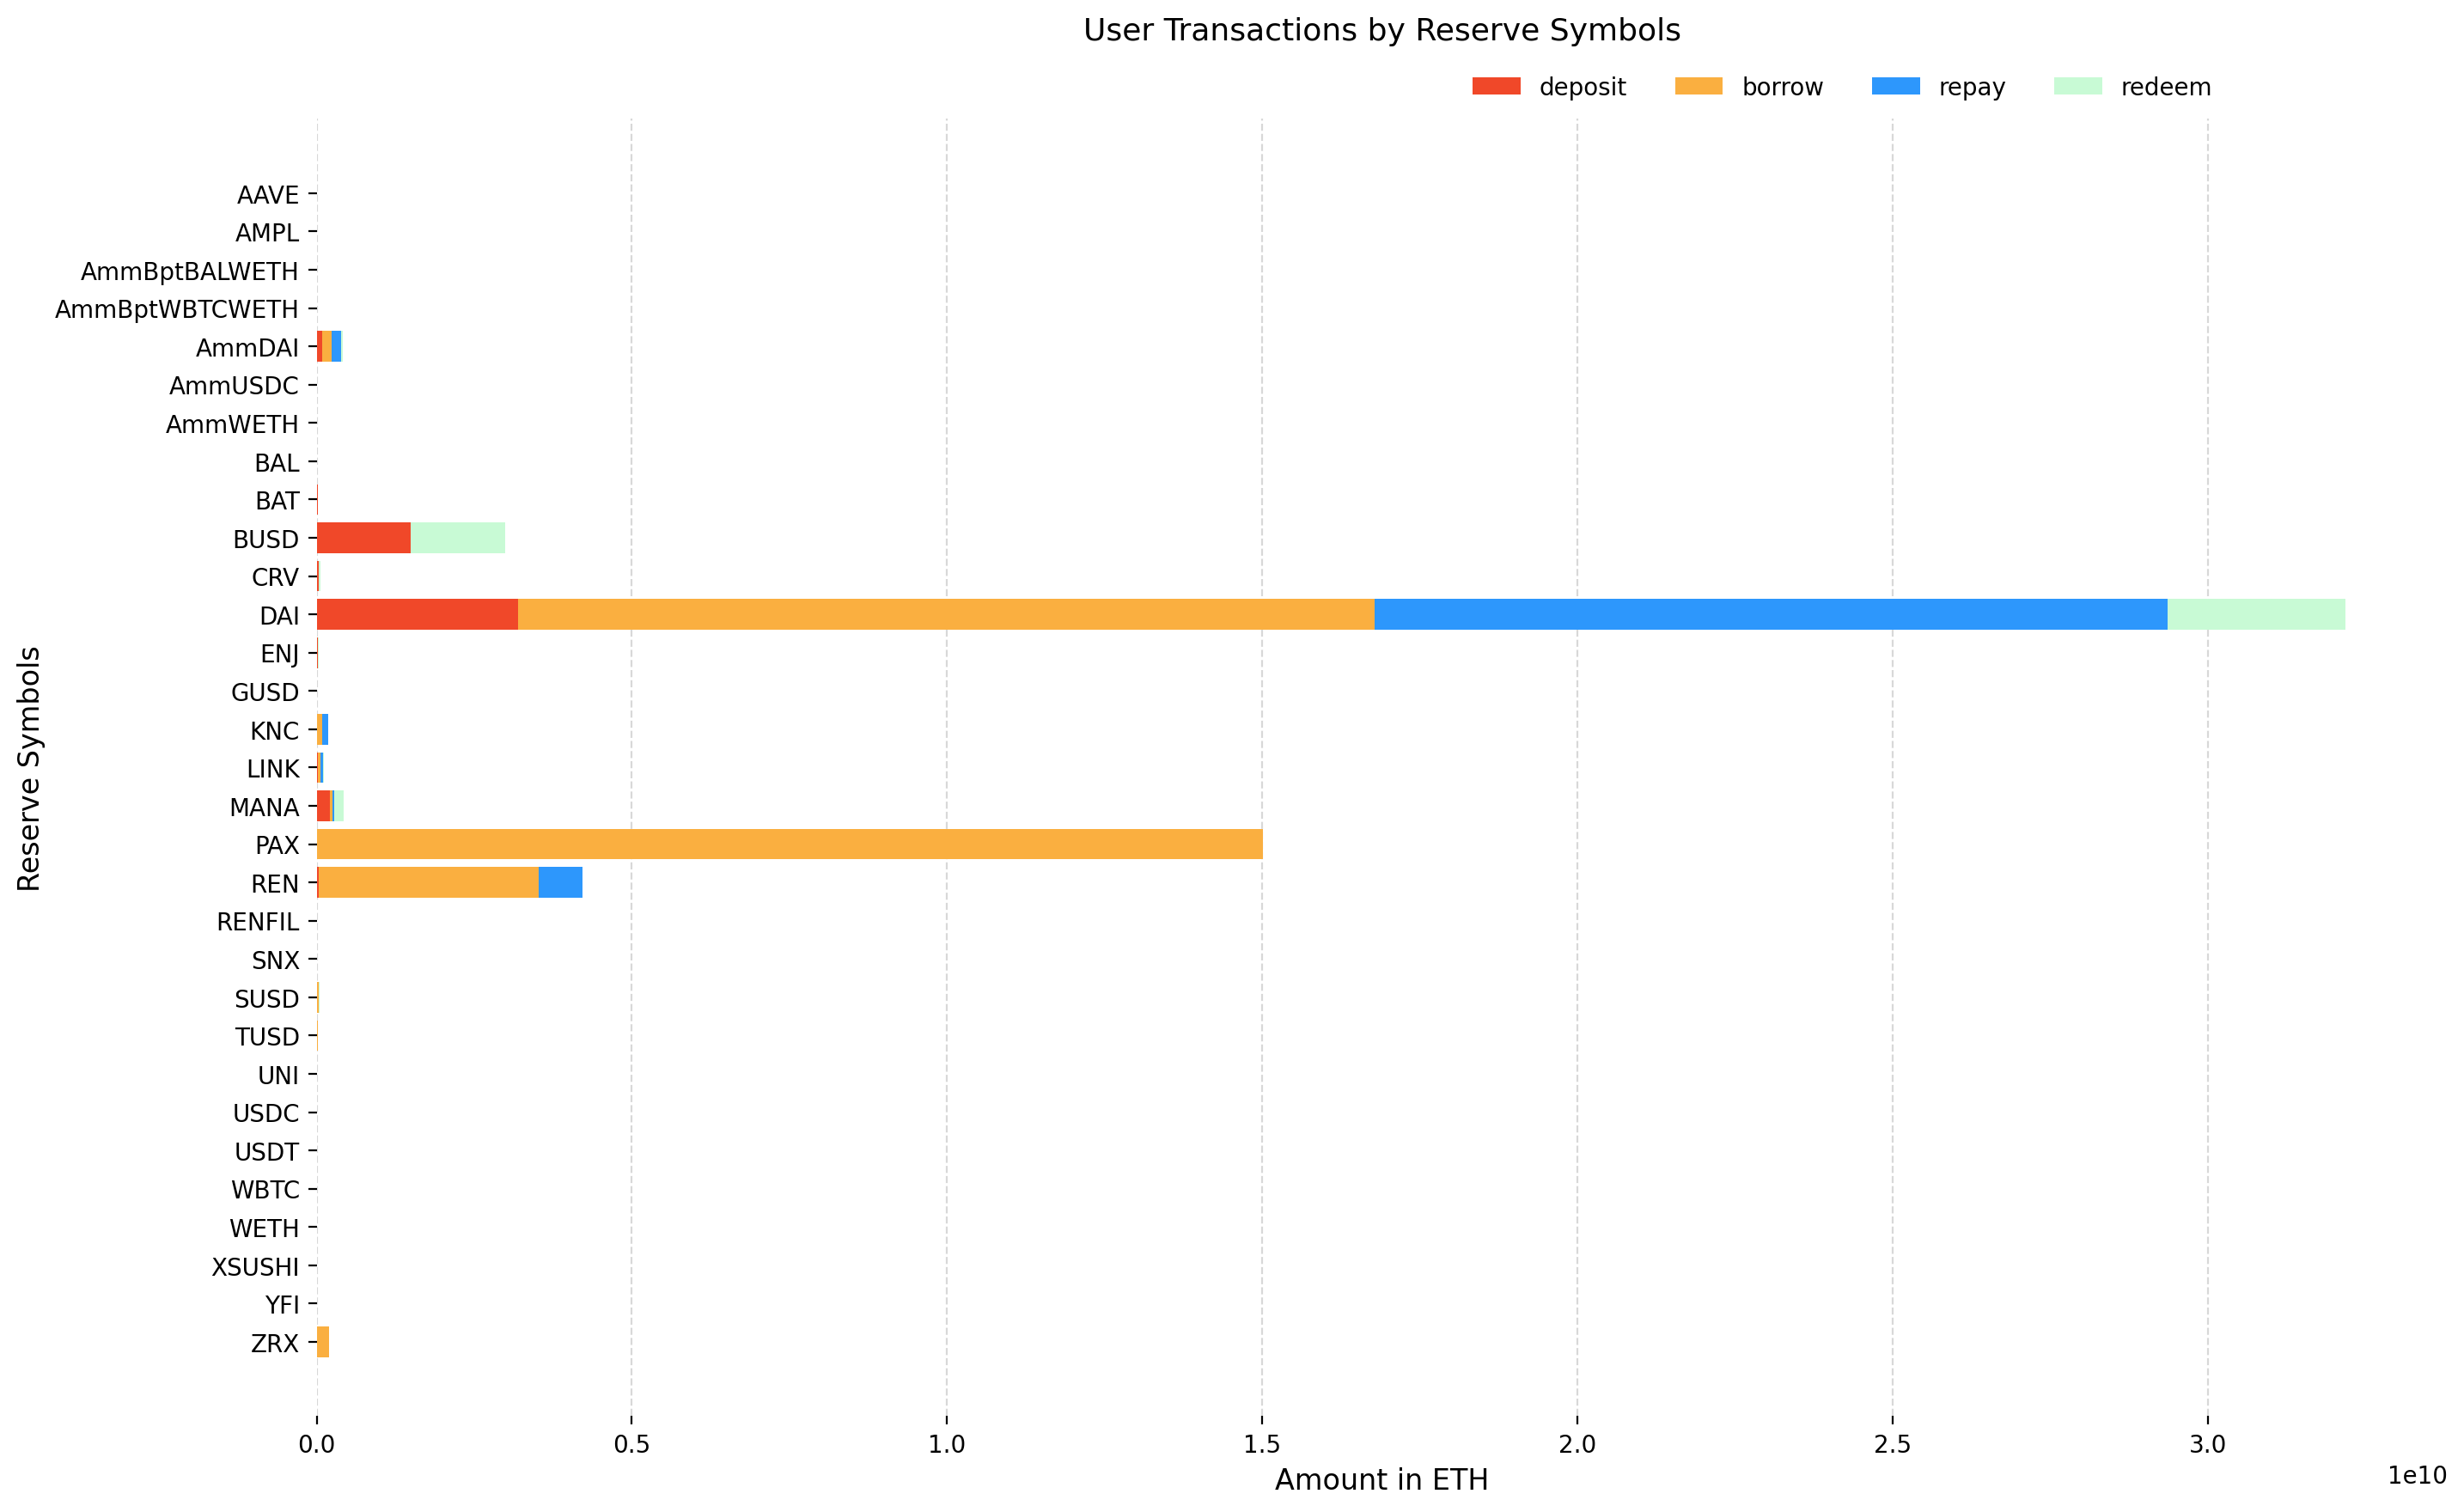

In [27]:
# merge and sort all the reserve symbols for y-axis value
y_labels = sorted(list(set(np.concatenate([deposits_group.index.values,
                        borrows_group.index.values, 
                        repays_group.index.values, 
                        redeems_group.index.values]))))

# obtain the transactions amount in eth for all the available reserve symbols for x-axis values
x_deposits = [deposits_group.loc[idx, 'deposit_amountInEth'] if idx in deposits_group.index.values else 0 
              for idx in y_labels]

x_borrows = [borrows_group.loc[idx, 'borrow_amountInEth'] if idx in borrows_group.index.values else 0 
              for idx in y_labels]

x_repays = [repays_group.loc[idx, 'repay_amountInEth'] if idx in repays_group.index.values else 0 
              for idx in y_labels]

x_redeems = [redeems_group.loc[idx, 'redeem_amountInEth'] if idx in redeems_group.index.values else 0 
              for idx in y_labels]

spectral_palette = {
    'red': '#F04829',
    'yellow': '#FAAF40',
    'blue': '#2D97FC',
    'green': '#C8FAD5'
}

height = 0.8

fig = plt.figure(figsize=(16, 10), dpi=100)
ax = fig.add_subplot(111)

labels = ['deposit', 'borrow', 'repay', 'redeem']
x_values = [x_deposits, x_borrows, x_repays, x_redeems]
colors = [spectral_palette['red'], spectral_palette['yellow'], 
          spectral_palette['blue'], spectral_palette['green']]

# create stacked barh plot
left = len(y_labels) * [0]
for x_value, label, color in zip(x_values, labels, colors):
    ax.barh(y_labels, x_value, label=label, color=color, height=height, left=left)
    left = np.add(left, x_value)

ax.invert_yaxis()
ax.legend(labels, bbox_to_anchor=([0.9, 1.05, 0, 0]), ncol=4, frameon=False)
ax.set_title('User Transactions by Reserve Symbols', y = 1.05, fontweight = 'light', fontsize = 13)
ax.set_xlabel('Amount in ETH', ha='center', fontsize = 12)
ax.set_ylabel('Reserve Symbols', ha='center', fontsize = 12)

# remove spines
for axis in ['right', 'left', 'top', 'bottom']:
    ax.spines[axis].set_visible(False)

# adjust limits and draw grid lines
#plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed', alpha=0.3)



We notice that total borrow transaction amount for `PAX` and `DAI` are exorbitant as compared to the remaining transactions. But, only `DAI` receives the most repayment. This is a good indicator of using either `MinMaxScaler` or `StandardScaler` as part of the pipeline.

Investigating further, this user `0x0000006daea1723962647b7e189d311d757fb793` is a very active user for the past 6 months.

In [28]:
max_borrow = borrowsAgg_df[borrowsAgg_df.borrow_amountInEth == borrowsAgg_df.borrow_amountInEth.max()]
print(f'User with largest borrow amount (user_id, borrow_amountInEth): {max_borrow.user_id.values[0]}, {max_borrow.borrow_amountInEth.values[0]}')

transactions_df[transactions_df.user_id == max_borrow.user_id.values[0]]


User with largest borrow amount (user_id, borrow_amountInEth): 0x0000006daea1723962647b7e189d311d757fb793, 15004055906.403587


,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions,deposit_reserve_symbol,deposit_amountInEth,borrow_reserve_symbol,borrow_amountInEth,repay_reserve_symbol,repay_amountInEth,redeem_reserve_symbol,redeem_amountInEth
12,0x0000006daea1723962647b7e189d311d757fb793,20.840227,20.840227,0.000013,BUSD,1.491864e+09,NaN,NaN,NaN,NaN,BUSD,1.496572e+09
13,0x0000006daea1723962647b7e189d311d757fb793,20.840227,20.840227,0.000013,CRV,2.559727e+05,NaN,NaN,NaN,NaN,CRV,2.559732e+05
14,0x0000006daea1723962647b7e189d311d757fb793,20.840227,20.840227,0.000013,USDC,3.118842e-02,NaN,NaN,NaN,NaN,USDC,1.793812e-02
15,0x0000006daea1723962647b7e189d311d757fb793,20.840227,20.840227,0.000013,USDT,1.650444e-05,USDT,3.000806e-08,USDT,3.001146e-08,USDT,1.650446e-05
16,0x0000006daea1723962647b7e189d311d757fb793,20.840227,20.840227,0.000013,WETH,1.076210e+04,WETH,3.000000e+03,WETH,3.000044e+03,WETH,6.510100e+03
135,0x0000006daea1723962647b7e189d311d757fb793,20.840227,20.840227,0.000013,NaN,NaN,DAI,1.190875e+10,DAI,1.190904e+10,NaN,NaN
136,0x0000006daea1723962647b7e189d311d757fb793,20.840227,20.840227,0.000013,NaN,NaN,KNC,8.950775e+07,KNC,8.959841e+07,NaN,NaN
137,0x0000006daea1723962647b7e189d311d757fb793,20.840227,20.840227,0.000013,NaN,NaN,PAX,1.500406e+10,NaN,NaN,NaN,NaN
138,0x0000006daea1723962647b7e189d311d757fb793,20.840227,20.840227,0.000013,NaN,NaN,REN,2.789595e+09,NaN,NaN,NaN,NaN
139,0x0000006daea1723962647b7e189d311d757fb793,20.840227,20.840227,0.000013,NaN,NaN,RENFIL,1.200795e+05,NaN,NaN,NaN,NaN


### 1.4. Identifying the target variable

Since now all the transaction amount is on ETH, we can savely summarize them for each users. We are also creating a new feature `debt_amountInEth` and `save_amountInEth`.

In [29]:
transactionsAgg_df = transactions_df.groupby(['user_id', 'user_unclaimedRewards', 'user_lifetimeRewards', 'user_incentivizedActions'], 
                        as_index=False) \
                                    .agg({'deposit_amountInEth': 'sum',
                                          'borrow_amountInEth': 'sum',
                                          'repay_amountInEth': 'sum',
                                          'redeem_amountInEth': 'sum'})

transactionsAgg_df['debt_amountInEth'] = transactionsAgg_df.borrow_amountInEth - transactionsAgg_df.repay_amountInEth
transactionsAgg_df['save_amountInEth'] = transactionsAgg_df.deposit_amountInEth - transactionsAgg_df.redeem_amountInEth

In [30]:
conditions = [
    ((transactionsAgg_df.debt_amountInEth <= 0) | 
        (transactionsAgg_df.debt_amountInEth / transactionsAgg_df.borrow_amountInEth < 0.5)),
    (transactionsAgg_df.debt_amountInEth / transactionsAgg_df.borrow_amountInEth  >= 0.5)
    
]

choices = [1, 0]
transactionsAgg_df['good_bad'] = np.select(conditions, choices, default=np.nan)

Subsequently, we are creating a `good_bad` variable that we will use as the target variable. The assumptions (with limited knowledge) are made to determine this `good_bad` value (i.e. good = 1, bad = 0) as below:
- Users with debt amount <= 0 or users who already repaid for more than half are considered good. Otherwise, they are considered bad.
- Out of those users that were considered good, if their saving are less than 30% and they do not own unclaimed rewards nor incentivized actions, then they will be considered bad.
- Additionally, those whose debt amount > 0 and saving amount <= 0 will be considered bad.

In [31]:
conditions = [
    ((transactionsAgg_df.save_amountInEth / transactionsAgg_df.deposit_amountInEth < 0.3) & 
        (transactionsAgg_df.user_unclaimedRewards == 0) & (transactionsAgg_df.user_incentivizedActions == 0) &
        (transactionsAgg_df.good_bad == 1)),
    ((transactionsAgg_df.debt_amountInEth > 0) & (transactionsAgg_df.save_amountInEth <= 0) &
        (transactionsAgg_df.good_bad == 1))
]

choices = [0, 0]

transactionsAgg_df['good_bad'] = np.select(conditions, choices, default=1)

In [32]:
transactionsAgg_df[transactionsAgg_df.good_bad == 0]

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions,deposit_amountInEth,borrow_amountInEth,repay_amountInEth,redeem_amountInEth,debt_amountInEth,save_amountInEth,good_bad
2,0x00000000005dbcb0d0513fcda746382fe8a53468,0.0,0.0,0.0,2.961793e+07,0.000000e+00,0.000000e+00,2.961848e+07,0.000000e+00,-5.530916e+02,0
6,0x0000000484f2217f1a64eb6d24b5cee446faeae5,0.0,0.0,0.0,5.050607e-03,0.000000e+00,3.000029e+02,5.050859e-03,-3.000029e+02,-2.512977e-07,0
14,0x0005ccfc729f11a55d4b4a30659a17c613d227f1,0.0,0.0,0.0,1.419936e-04,0.000000e+00,0.000000e+00,1.420657e-04,0.000000e+00,-7.211324e-08,0
21,0x0008d79c3276ed8bce0b22036bcbab9638a2c8c8,0.0,0.0,0.0,2.050000e-01,4.465782e+05,4.465782e+05,2.040000e-01,0.000000e+00,1.000000e-03,0
25,0x000b79f52356189c80a9d3ada3911d4438218516,0.0,0.0,0.0,4.904854e+02,0.000000e+00,0.000000e+00,4.904854e+02,0.000000e+00,0.000000e+00,0
26,0x000ba2873dbf3fed35d974d3bcbb8ed68fabdfa9,0.0,0.0,0.0,0.000000e+00,0.000000e+00,3.651912e+06,1.842824e+04,-3.651912e+06,-1.842824e+04,0
29,0x000f75539c2bc3941e4a29acb1d9a8254eff427f,0.0,0.0,0.0,9.858301e+07,1.497623e-04,3.600112e+01,9.157313e+07,-3.600097e+01,7.009876e+06,0
30,0x000f7f22bfc28d940d4b68e13213ab17cf107790,0.0,0.0,0.0,2.127556e-02,4.184561e+07,4.184632e+07,2.127754e-02,-7.099512e+02,-1.983023e-06,0
32,0x001286273fda460f4f1827613ca9dfa70ae239d0,0.0,0.0,0.0,1.478072e+04,0.000000e+00,0.000000e+00,1.485817e+04,0.000000e+00,-7.745060e+01,0
44,0x002190e2f72c750bdca1784c3b1344fc2f785992,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,8.365138e-05,0.000000e+00,-8.365138e-05,0


In [33]:
def display_proportion(data, lengths, title):
    """
    Visualize before and after data sampling
    """
    
    fig = plt.figure(figsize=(8, 4), dpi=100)
    
    for i, (d, l, t) in enumerate(zip(data, lengths, title)):

        ax = fig.add_subplot(1,2,i+1)

        ax.bar(d.index, d.values * 100, width=0.4, align='center', zorder=10,
               color=[spectral_palette['blue'], spectral_palette['red']])

        # show text label
        for idx, bar in enumerate(ax.patches):
            bar_value = bar.get_height()
            text = f'{bar_value:,.3f} ({l.iloc[idx]})'
            text_x = bar.get_x() + bar.get_width() / 2
            text_y = bar.get_y() + bar_value
            bar_color = bar.get_facecolor()
            ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color, size=8)

        ax.set_title(t, y = 1.05, fontweight = 'light', fontsize = 9)
        ax.set_xlabel('Classes', ha='center', fontsize = 9)
        ax.set_ylabel('Percentage', ha='center', fontsize = 9)    

        ax.set_xticks(d.index)
        ax.set_xticklabels(['good','bad'])

        ax.yaxis.grid(True, color='gray', ls='--', alpha=0.2)
        ax.yaxis.set_ticks(np.arange(0, 100, 20))
        ax.tick_params(axis='both', labelsize=8, bottom=False, length=2)

        # remove spines
        for axis in ['right', 'top']:
            ax.spines[axis].set_visible(False)

        for axis in ['left', 'bottom']:
            ax.spines[axis].set_linewidth(0.5)
            ax.spines[axis].set_alpha(0.3)

    plt.suptitle('Target Variable Proportion', fontsize=9.5)

    fig.tight_layout(pad=5)
    fig.subplots_adjust(top=0.82)

We want to split the dataset size to 0.8 train and 0.2 test. Due to the imbalance class of our target variable, we apply `SVMSMOTE` to oversample the minority class (i.e., bad). And to ensure the sampling will have similar range, we want to apply `StandardScaler` to our features (minus the `debt_amountInEth` and `save_amountInEth`) prior.

In [34]:
X_cols = transactionsAgg_df.select_dtypes('float64').columns[:-2]
y_col = transactionsAgg_df.select_dtypes('int').columns

X = transactionsAgg_df[np.concatenate((['user_id'], X_cols.values))].copy() # transactionsAgg_df[X_cols].copy()
y = transactionsAgg_df[y_col].copy()

In [35]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# drop user_id for X_train
X_train = X_train[X_cols]

# keep user_id from test dataset and drop it afterwards
X_test_user = X_test[['user_id']]
X_test = X_test[X_cols]

# preparing for proportion visualization between good and bad
prop_bef = y_train

y_train = y_train.to_numpy(copy=True).ravel()
y_test = y_test.to_numpy(copy=True).ravel()

In [36]:
# run standard scaler for numerical values then over sample
scaler = StandardScaler()
oversample = SVMSMOTE()

X_train = scaler.fit_transform(X_train)
X_train, y_train = oversample.fit_resample(X_train, y_train)

# preparing for proportion visualization between good and bad
prop_after = pd.DataFrame(y_train, columns=['good_bad'])

# transform test data
X_test = scaler.transform(X_test)


We can see that we have a balanced class now after oversampling the minority class.

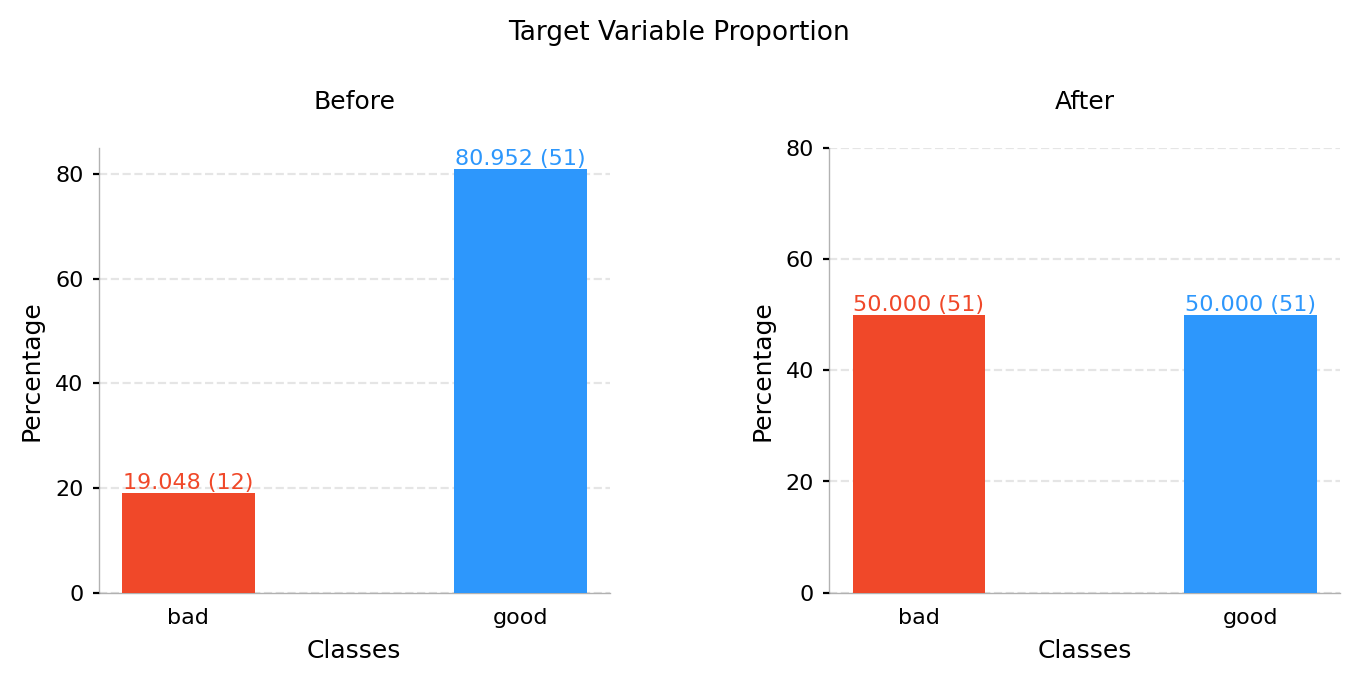

In [37]:
target_proportion = prop_bef['good_bad'].value_counts(normalize = True)
target_proportion_len = prop_bef['good_bad'].value_counts(normalize = False)

target_proportion_after = prop_after['good_bad'].value_counts(normalize = True)
target_proportion_after_len = prop_after['good_bad'].value_counts(normalize = False)

display_proportion([target_proportion, target_proportion_after], 
                   [target_proportion_len, target_proportion_after_len],
                   ['Before','After'])

## 2. Building the model

In [38]:
import re

import seaborn as sns
import pandas.core.algorithms as algos
import scipy.stats.stats as stats

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc

from heatmap import heatmap, corrplot

#sns.set(color_codes=True, font_scale=1.2)

%load_ext autoreload
%autoreload 2

### 2.1. Features Importance & Multicolinearity

In [39]:
F_statistic, p_values = f_classif(X_train, y_train)

ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_cols, 
                                     'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})

ANOVA_F_table.sort_values(by=['F-Score'], ascending=False, ignore_index=True, inplace=True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,user_lifetimeRewards,5.956481,0.016422
1,deposit_amountInEth,2.892570,0.092097
2,user_incentivizedActions,2.857566,0.094060
3,user_unclaimedRewards,2.299045,0.132608
4,redeem_amountInEth,2.255294,0.136309
5,borrow_amountInEth,1.122785,0.291872
6,repay_amountInEth,1.110935,0.294419


Using ANOVA, there seems that none of the features are statistically significant. We will use all the features since the number of features is limited. For the important features, we can see that the `user_lifetimeRewards` has the highest F1-score.

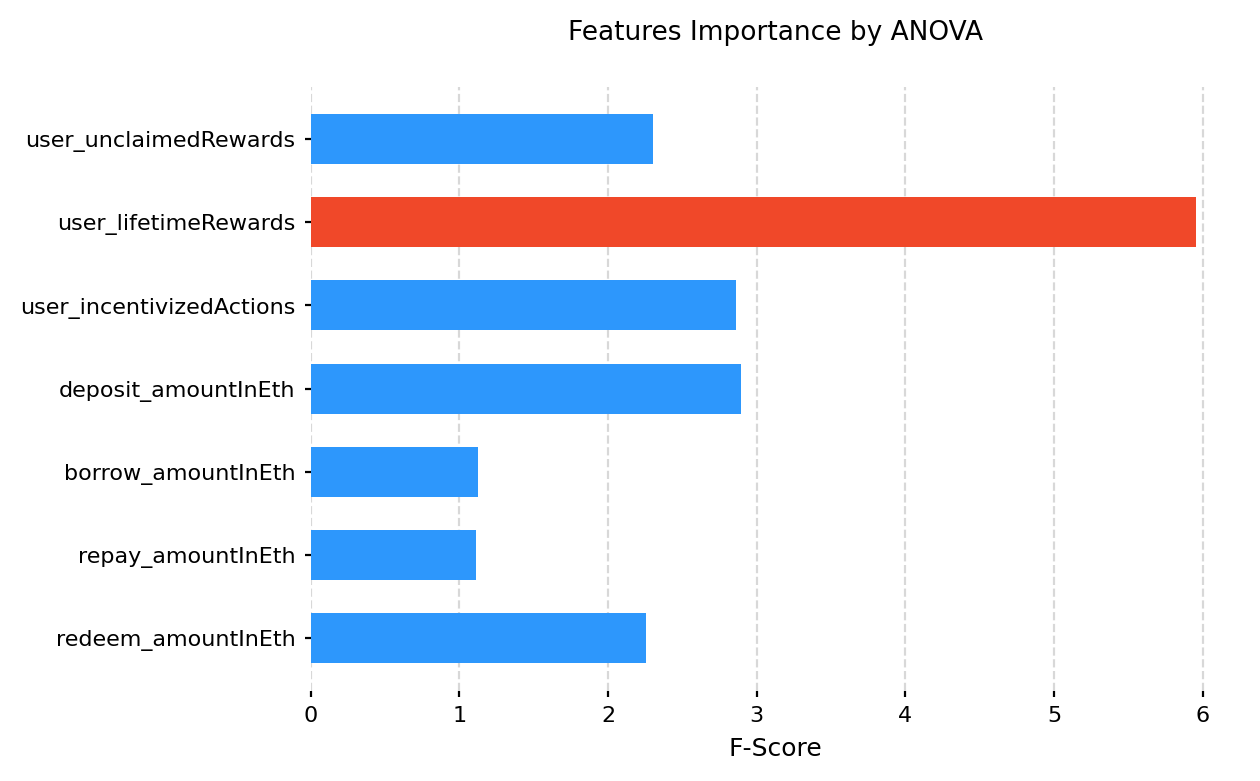

In [40]:
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

fig = plt.figure(figsize=(6, 4), dpi=100)

ax = fig.add_subplot(111)

colors = [spectral_palette['blue'] if (score < max(fs.scores_)) 
          else spectral_palette['red'] for score in fs.scores_ ]
ax.barh([X_cols[i] for i in range(len(fs.scores_))], fs.scores_, height=0.6, color=colors)

ax.invert_yaxis()
ax.set_title('Features Importance by ANOVA', y = 1.05, fontweight = 'light', fontsize = 9.5)
ax.set_xlabel('F-Score', ha='center', fontsize = 9)
#ax.set_ylabel('Reserve Symbols', ha='center', fontsize = 12)
ax.tick_params(axis='both', labelsize=8, length=2)

# remove spines
for axis in ['right', 'left', 'top', 'bottom']:
    ax.spines[axis].set_visible(False)

# adjust limits and draw grid lines
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed', alpha=0.3)

Observing the correlation matrix, there appears multicolinearity on (`user_unclaimRewards`, `borrow_amountInEth`), (`deposit_amountInEth`, `redeem_amountInEth`), and (`borrow_amountInEth`, `repay_amountInEth`), which makes sense. And therefore, we will drop `user_unclaimRewards`, `repay_amountInEth`, and `redeem_amountInEth`.

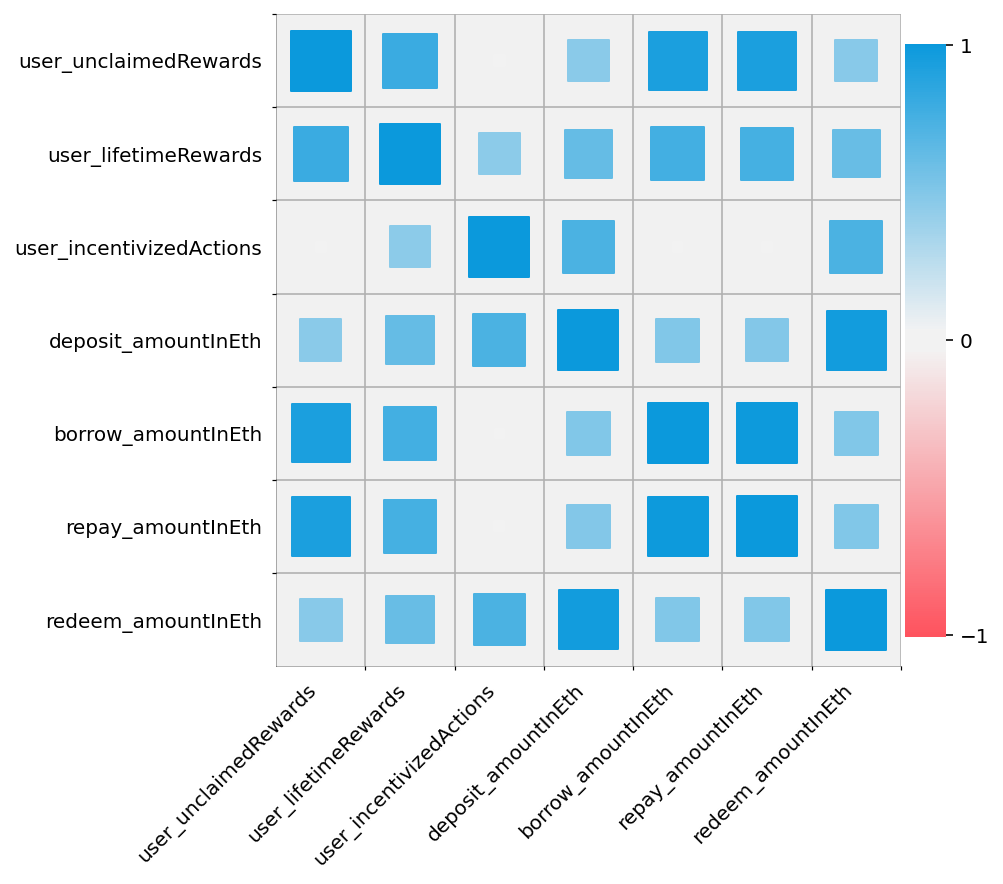

In [41]:
X_train_df = pd.DataFrame(X_train_fs, columns=X_cols)

plt.figure(figsize=(6, 6))
corrplot(X_train_df.corr(), size_scale=900)


In [42]:
# drop repay and redeem feature
X_train_fs = X_train_fs[:,1:-2]
X_test_fs = X_test_fs[:,1:-2]
X_cols = X_cols[1:-2]

### 2.2. Analyzing WoEs and IV

In [43]:
X_train_df = pd.DataFrame(X_train_fs, columns=X_cols)
y_train_df = pd.DataFrame(y_train, columns=y_col)

Weight of Evidence (WoE) and Information Value (IV) are powerful techniques to perform variable transformation and selection. It is widely used in credit scoring to measure the separation between good user and bad user.

Below are the formula to calculate WoE and IV.

$$\text{WoE} = \ln \, \left(  \dfrac{\% \, \text{Event (good)}}{\% \, \text{Non Event (bad)}} \right)$$

$$\text{IV} = \sum (\% \, \text{Event (good)} - \% \, \text{Non Event (bad)}) * \text{WoE}$$

We use spearman correlation to perform monotonic binning.

In [44]:
def numerical_bin(Y, X, max_bin, force_bin):
    """
    Binning function for numerical feature
    """
    df1 = pd.DataFrame({"X": X, "Y": Y})
    missing = df1[['X','Y']][df1.X.isnull()]
    no_missing = df1[['X','Y']][df1.X.notnull()]
    r = 0
    n = max_bin
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": no_missing.X, "Y": no_missing.Y, "Bucket": pd.qcut(no_missing.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            # use spearman correlation to as monotonic function
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(no_missing.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1] / 2)
        d1 = pd.DataFrame({"X": no_missing.X, "Y": no_missing.Y, 
                           "Bucket": pd.cut(no_missing.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)

    d3 = pd.DataFrame({}, index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(missing.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan}, index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = missing.count().Y
        d4["EVENT"] = missing.sum().Y
        d4["NONEVENT"] = missing.count().Y - missing.sum().Y
        d3 = d3.append(d4, ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT / d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT / d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT / d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT / d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT - d3.DIST_NON_EVENT) * d3.WOE # np.log(d3.DIST_EVENT / d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 
             'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return d3

def categorical_bin(Y, X):
    """
    Binning feature for categorical feature
    """
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    missing = df1[['X','Y']][df1.X.isnull()]
    no_missing = df1[['X','Y']][df1.X.notnull()]    
    df2 = no_missing.groupby('X', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(missing.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan}, index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = missing.count().Y
        d4["EVENT"] = missing.sum().Y
        d4["NONEVENT"] = missing.count().Y - missing.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT / d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT / d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT / d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT / d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT / d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT - d3.DIST_NON_EVENT) * d3.WOE # np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 
             'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return d3

def data_vars(df1, target, max_bin=10, force_bin=3):
    """
    Calculate the WoE and IV for binning reference
    """
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if np.issubdtype(df1[i], np.number) and len(pd.Series.unique(df1[i])) > 2:
            conv = numerical_bin(target, df1[i], max_bin, force_bin)
            conv["VAR_NAME"] = i
            count = count + 1
        else:
            conv = categorical_bin(target, df1[i])
            conv["VAR_NAME"] = i            
            count = count + 1

        if count == 0:
            iv_df = conv
        else:
            iv_df = iv_df.append(conv, ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    
    return iv_df, iv

In [45]:
iv, IV_summary = data_vars(X_train_df, y_train_df.good_bad, max_bin=10)
iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,user_lifetimeRewards,-0.307081,-0.162738,90,39,0.433333,51,0.566667,0.764706,1.000000,-0.268264,0.063121
1,user_lifetimeRewards,-0.102362,0.843322,8,8,1.000000,0,0.000000,0.156863,0.000000,0.000000,0.063121
2,user_lifetimeRewards,1.884306,5.998157,4,4,1.000000,0,0.000000,0.078431,0.000000,0.000000,0.063121
3,user_incentivizedActions,-0.213933,-0.192657,95,44,0.463158,51,0.536842,0.862745,1.000000,-0.147636,0.020264
4,user_incentivizedActions,-0.055890,0.475107,5,5,1.000000,0,0.000000,0.098039,0.000000,0.000000,0.020264
5,user_incentivizedActions,3.563722,6.862643,2,2,1.000000,0,0.000000,0.039216,0.000000,0.000000,0.020264
6,deposit_amountInEth,-0.221387,-0.221368,51,22,0.431373,29,0.568627,0.431373,0.568627,-0.276253,0.075834
7,deposit_amountInEth,-0.221368,6.539192,51,29,0.568627,22,0.431373,0.568627,0.431373,0.276253,0.075834
8,borrow_amountInEth,-0.135115,-0.095392,99,48,0.484848,51,0.515152,0.941176,1.000000,-0.060625,0.003566
9,borrow_amountInEth,0.029960,0.127947,2,2,1.000000,0,0.000000,0.039216,0.000000,0.000000,0.003566


In [46]:
IV_summary

,VAR_NAME,IV
0,borrow_amountInEth,0.003566
1,deposit_amountInEth,0.075834
2,user_incentivizedActions,0.020264
3,user_lifetimeRewards,0.063121


| Information Value | Predictive Power |
|-------------------|------------------|
| < 0.02            | useless          |
| 0.02 to 0.1       | weak             |
| 0.1 to 0.3        | medium           |
| 0.3 to 0.5        | strong           |
| > 0.5             | suspicious       |


Based on the IV table above, the `deposit_amountInEth` appears to be a medium predictor and the `borrow_amountInEth` appears to be useless one.

### 2.3. Defining WoE binning classes

To create appropriate WoE binning, below are the rules of thumb.
1. Each bin should have at least 5% of the observations
2. Each bin should be non-zero for both good and bad loans
3. The WOE should be distinct for each category. Similar groups should be aggregated or binned together. It is because the bins with similar WoE have almost the same proportion of good or bad loans, implying the same predictive power
4. The WOE should be monotonic, i.e., either growing or decreasing with the bins
5. Missing values are binned separately

In [47]:
ref_categories = ['user_lifetimeRewards:>0.0358875', 'user_incentivizedActions:>(-0.1971357)',
                  'deposit_amountInEth:>(-0.19191799)', 'borrow_amountInEth:>(-0.131896667)']

class WoEBinning(BaseEstimator, TransformerMixin):
    
    def __init__(self, X):
        self.X = X
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        """
        Binning users based on pre-defined categories
        """
        
        _X = pd.DataFrame({})
        _X['user_lifetimeRewards:<(-0.3070806)'] = np.where((X['user_lifetimeRewards'] <= -0.3070806), 1, 0)
        _X['user_lifetimeRewards:(-0.3070806)-0.0358875'] = np.where((X['user_lifetimeRewards'] > -0.3070806) &
                                                                     (X['user_lifetimeRewards'] <= 0.0358875), 1, 0)
        _X['user_lifetimeRewards:>0.0358875'] = np.where((X['user_lifetimeRewards'] > 0.0358875), 1, 0)
        _X['user_lifetimeRewards:missing'] = np.where((X['user_lifetimeRewards'].isnull()), 1, 0)
        
        _X['user_incentivizedActions:<(-0.213932548)'] = \
            np.where((X['user_incentivizedActions'] <= -0.213932548), 1, 0)
        _X['user_incentivizedActions:(-0.213932548)-(-0.1971357)'] = \
            np.where((X['user_incentivizedActions'] > -0.213932548) & 
                     (X['user_incentivizedActions'] <= -0.1971357), 1, 0)
        _X['user_incentivizedActions:>(-0.1971357)'] = \
            np.where((X['user_incentivizedActions'] > -0.1971357), 1, 0)
        _X['user_incentivizedActions:missing'] = np.where((X['user_incentivizedActions'].isnull()), 1, 0)
        
        _X['deposit_amountInEth:<(-0.22100477)'] = np.where((X['deposit_amountInEth'] <= -0.22100477), 1, 0)
        _X['deposit_amountInEth:(-0.22100477)-(-0.2210047553696)'] = \
            np.where((X['deposit_amountInEth'] > -0.22100477) &
                     (X['deposit_amountInEth'] <= -0.2210047553696), 1, 0)
        _X['deposit_amountInEth:(-0.2210047553696)-(-0.22100395)'] = \
            np.where((X['deposit_amountInEth'] > -0.2210047553696) &
                     (X['deposit_amountInEth'] <= -0.22100395), 1, 0)
        _X['deposit_amountInEth:(-0.22100395)-(-0.19191799)'] = \
            np.where((X['deposit_amountInEth'] > -0.22100395) &
                     (X['deposit_amountInEth'] <= -0.19191799), 1, 0)
        _X['deposit_amountInEth:>(-0.19191799)'] = \
            np.where((X['deposit_amountInEth'] > -0.19191799), 1, 0)
        _X['deposit_amountInEth:missing'] = np.where((X['deposit_amountInEth'].isnull()), 1, 0)
        
        _X['borrow_amountInEth:<(-0.13505588499518)'] = np.where((X['borrow_amountInEth'] <= -0.13505588499518), 1, 0)
        _X['borrow_amountInEth:(-0.13505588499518)-(-0.131896667)'] = \
            np.where((X['borrow_amountInEth'] > -0.13505588499518) &
                     (X['borrow_amountInEth'] <= -0.131896667), 1, 0)
        _X['borrow_amountInEth:>(-0.131896667)'] = np.where((X['borrow_amountInEth'] > -0.131896667), 1, 0)
        _X['borrow_amountInEth:missing'] = np.where((X['borrow_amountInEth'].isnull()), 1, 0)
        
        _X.drop(columns = ref_categories, inplace = True)
        
        return _X
        
        

### 2.4. Time for modeling

We run our modeling with a pipeline through `WOEBinning`, and followed with `LogisticRegression`. We use cross-validation with number of splits equals to 20 and repeats of 50.

In [48]:
# create model pipeline
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoEBinning(X_train_df)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

# create cross-validation criteria.
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=50, random_state=42)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, X_train_df, y_train, scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)
GINI = AUROC * 2 - 1

print('Mean AUROC: %.4f' % (AUROC))
print('Gini: %.4f' % (GINI))

Mean AUROC: 0.8026
Gini: 0.6051


We achive AUROC of 0.8026 on the train dataset, which is not too bad. Considering we have a limited dataset and features after all. And more importantly, we are making assumptions to define the 'good' and the 'bad' users.

In [49]:
pipeline.fit(X_train_df, y_train)

Pipeline(steps=[('woe',
                 WoEBinning(X=     user_lifetimeRewards  user_incentivizedActions  deposit_amountInEth  \
0               -0.307081                 -0.213933            -0.221368   
1               -0.061661                 -0.213722            -0.212991   
2               -0.307080                 -0.213933            -0.221368   
3               -0.307053                 -0.213843            -0.221368   
4               -0.307081                 -0.213933            -0.221368   
..                    ...                       ...                  ...   
97              -0.307081                 -0.213933            -0.221368   
98              -0.307081                 -0.213933            -0.221368   
99              -0.307081                 -0.213933            -0.221368   
100             -0.307081                 -0.213933            -0.221368   
101             -0.307081                 -0.213933            -0.221368   

     borrow_amountInEth  
0      

Below is the summary table of our `LogisticRegression` model coefficients.

In [50]:
# create a transformed training set through the WoEBinning class
X_train_woe_transformed = woe_transform.fit_transform(X_train_df)
# keep the column names from woe transformed X_train
feature_name = X_train_woe_transformed.columns.values
# create a summary table of the logistic regression model
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# create a new column 'Coefficients' from the transposed coefficients of the 'LogisticRegression' model
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
# increase the index of every row of the dataframe with 1 to store our model intercept in 1st row
summary_table.index = summary_table.index + 1
# assign the model intercept to index 0
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
# sort by index
summary_table.sort_index(inplace = True)
summary_table

,Feature name,Coefficients
0,Intercept,2.405070
1,user_lifetimeRewards:<(-0.3070806),-1.501271
2,user_lifetimeRewards:(-0.3070806)-0.0358875,0.507021
3,user_lifetimeRewards:missing,0.000000
4,user_incentivizedActions:<(-0.213932548),-1.418751
5,user_incentivizedActions:(-0.213932548)-(-0.19...,0.771734
6,user_incentivizedActions:missing,0.000000
7,deposit_amountInEth:<(-0.22100477),-0.499033
8,deposit_amountInEth:(-0.22100477)-(-0.22100475...,0.000000
9,deposit_amountInEth:(-0.2210047553696)-(-0.221...,0.000000


## 3. Model prediction and evaluation

### 3.1. Time for prediction

We run our prediction on the test dataset and obtain the predicted probablities.

In [51]:
# make preditions on our test set
X_test_df = pd.DataFrame(X_test_fs, columns=X_cols)
y_hat_test = pipeline.predict(X_test_df)
# get the predicted probabilities
y_hat_test_proba = pipeline.predict_proba(X_test_df)
# select the probabilities of only the positive class (class 1 - default) 
y_hat_test_proba = y_hat_test_proba[:][:, 1]

### 3.2. Model performance evaluation

In [52]:
# create a new dataframe with actual classes and the predicted probabilities
y_test_proba = pd.concat([pd.DataFrame(y_test), pd.DataFrame(y_hat_test_proba)], axis = 1)
y_test_proba.shape

(16, 2)

In [53]:
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
y_test_proba.index = X_test_user['user_id'].values
y_test_proba

,y_test_class_actual,y_hat_test_proba
0x000cef8f0ab0a2fadbecaeb92e8781ab3e04b01e,1,0.337104
0x000000000a38444e0a6e37d3b630d7e855a7cb13,1,0.971323
0x0008d79c3276ed8bce0b22036bcbab9638a2c8c8,0,0.117874
0x004f137c71b3003c7915bd6aa3a4f57e334a738e,1,0.917818
0x001a9d8fc5916cf5a1c43dbca0e937006fa1412a,1,0.337104
0x001076a29493cf2ace3474bfe308688effaf12cb,1,0.939959
0x00159370cbe576b765a7fb2e78582e0cb563d445,1,0.960448
0x00000000000cd56832ce5dfbcbff02e7ec639bc9,1,0.960258
0x002d7b197fdb0701713769df5ca0edeb1b2e988f,1,0.337104
0x00357a57310cccfb750a5ecb2948b516df6565f5,1,0.337104


In [54]:
tr = 0.5
# create y_test_class_predicted from the given threshold
y_test_proba['y_test_class_predicted'] = np.where(y_test_proba['y_hat_test_proba'] > tr, 1, 0)
# create the confusion matrix
confusion_matrix(y_test_proba['y_test_class_actual'], y_test_proba['y_test_class_predicted'], normalize = 'all')

array([[0.1875, 0.    ],
       [0.3125, 0.5   ]])

Our model has approximately ~31% of false negative. In other words, it predicts ~31% that users are bad despite they are good users.

In [55]:
# calculate the roc score and display the curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])

AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
Gini = AUROC * 2 - 1

# calculate the precision recall
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], 
                                                       y_test_proba['y_hat_test_proba'])

no_skill = len(y_test[y_test == 1]) / len(y)

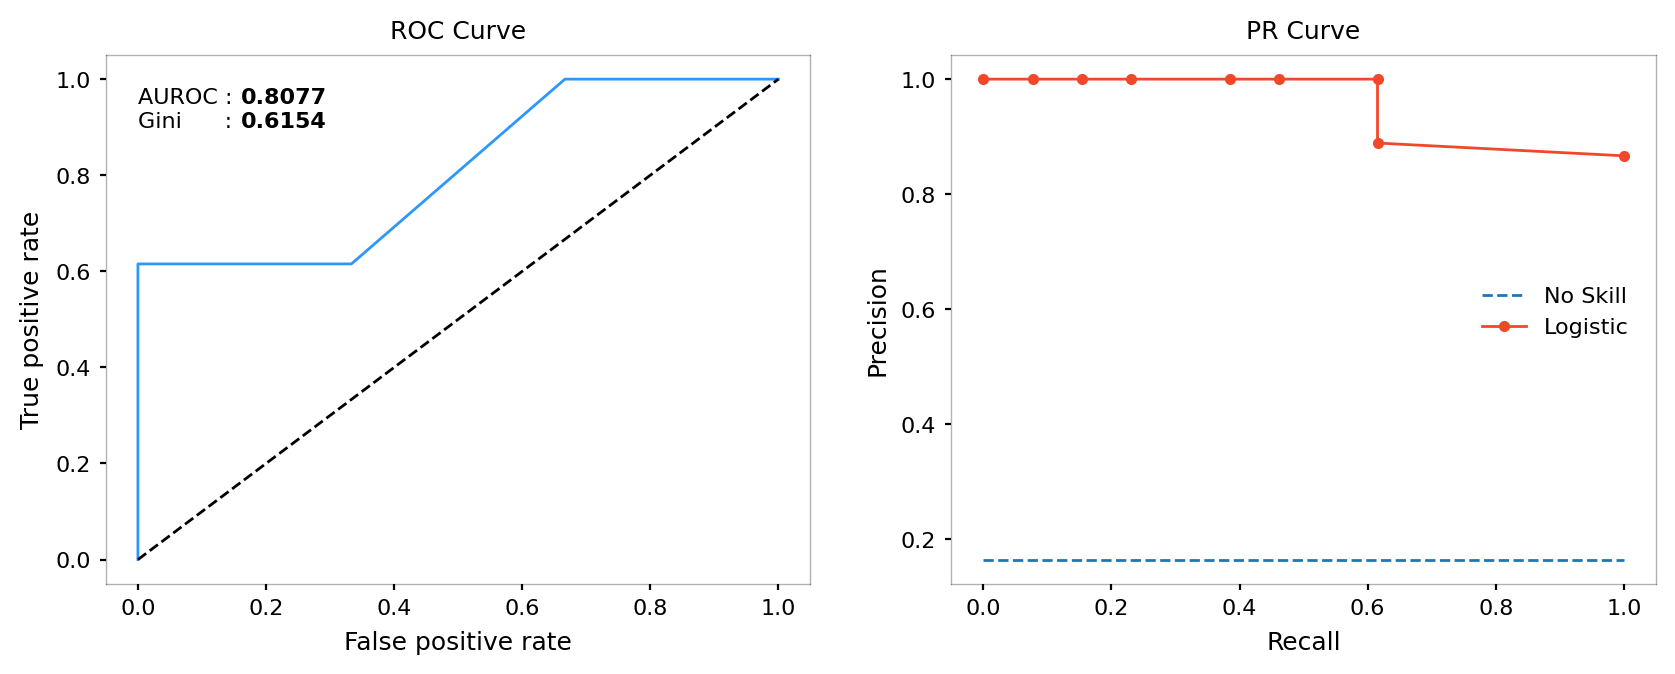

In [56]:
fig = plt.figure(figsize=(10, 3.5), dpi=100)

ax = fig.add_subplot(121)

ax.plot(fpr, tpr, color=spectral_palette['blue'], lw=1)
ax.plot(fpr, fpr, linestyle = '--', color = 'k', lw=1)
ax.text(0, 0.95, 'AUROC :', fontsize = 8)
ax.text(0.16, 0.95, f'{AUROC:.4f}', fontsize = 8, weight='bold')
ax.text(0, 0.9, 'Gini      :', fontsize = 8)
ax.text(0.16, 0.9, f'{Gini:.4f}', fontsize = 8, weight='bold')

ax.set_title('ROC Curve', fontweight = 'light', fontsize = 9)
ax.set_xlabel('False positive rate', ha='center', fontsize = 9)
ax.set_ylabel('True positive rate', ha='center', fontsize = 9)

ax.tick_params(axis='both', labelsize=8, length=2)

for axis in ['left', 'bottom', 'right', 'top']:
    ax.spines[axis].set_linewidth(0.5)
    ax.spines[axis].set_alpha(0.3)
    
    
ax = fig.add_subplot(122)
ax.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill', lw=1)
ax.plot(recall, precision, marker='.', color= spectral_palette['red'], lw=1, label='Logistic')

ax.set_title('PR Curve', fontweight = 'light', fontsize = 9)
ax.set_xlabel('Recall', ha='center', fontsize = 9)
ax.set_ylabel('Precision', ha='center', fontsize = 9)

ax.legend(frameon=False, fontsize=8, bbox_to_anchor=([0.99, 0.6, 0, 0]))
ax.tick_params(axis='both', labelsize=8, length=2)

for axis in ['left', 'bottom', 'right', 'top']:
    ax.spines[axis].set_linewidth(0.5)
    ax.spines[axis].set_alpha(0.3)

Also, our model has AUROC of 0.8077 with limited test dataset. We should not rely on the precission-recall however, since the majority of users in test dataset are good users. And therefore, we see high precision here.

## 4. Applying model to scorecard

### 4.1. Creating scorecard

And this phase, we are calculating the scorecard as the basis of the users' credit score.

In [57]:
summary_table

,Feature name,Coefficients
0,Intercept,2.405070
1,user_lifetimeRewards:<(-0.3070806),-1.501271
2,user_lifetimeRewards:(-0.3070806)-0.0358875,0.507021
3,user_lifetimeRewards:missing,0.000000
4,user_incentivizedActions:<(-0.213932548),-1.418751
5,user_incentivizedActions:(-0.213932548)-(-0.19...,0.771734
6,user_incentivizedActions:missing,0.000000
7,deposit_amountInEth:<(-0.22100477),-0.499033
8,deposit_amountInEth:(-0.22100477)-(-0.22100475...,0.000000
9,deposit_amountInEth:(-0.2210047553696)-(-0.221...,0.000000


In [58]:
ref_categories_df = pd.DataFrame(ref_categories, columns = ['Feature name'])
# create 'Coefficients' with only 0 values.
ref_categories_df['Coefficients'] = 0
ref_categories_df

,Feature name,Coefficients
0,user_lifetimeRewards:>0.0358875,0
1,user_incentivizedActions:>(-0.1971357),0
2,deposit_amountInEth:>(-0.19191799),0
3,borrow_amountInEth:>(-0.131896667),0


In [59]:
scorecard_df = pd.concat([summary_table, ref_categories_df])
scorecard_df.reset_index(inplace = True)
scorecard_df

,index,Feature name,Coefficients
0,0,Intercept,2.405070
1,1,user_lifetimeRewards:<(-0.3070806),-1.501271
2,2,user_lifetimeRewards:(-0.3070806)-0.0358875,0.507021
3,3,user_lifetimeRewards:missing,0.000000
4,4,user_incentivizedActions:<(-0.213932548),-1.418751
5,5,user_incentivizedActions:(-0.213932548)-(-0.19...,0.771734
6,6,user_incentivizedActions:missing,0.000000
7,7,deposit_amountInEth:<(-0.22100477),-0.499033
8,8,deposit_amountInEth:(-0.22100477)-(-0.22100475...,0.000000
9,9,deposit_amountInEth:(-0.2210047553696)-(-0.221...,0.000000


In [60]:
# create a new column 'Original feature name'
scorecard_df['Original feature name'] = scorecard_df['Feature name'].str.split(':').str[0]
scorecard_df

,index,Feature name,Coefficients,Original feature name
0,0,Intercept,2.405070,Intercept
1,1,user_lifetimeRewards:<(-0.3070806),-1.501271,user_lifetimeRewards
2,2,user_lifetimeRewards:(-0.3070806)-0.0358875,0.507021,user_lifetimeRewards
3,3,user_lifetimeRewards:missing,0.000000,user_lifetimeRewards
4,4,user_incentivizedActions:<(-0.213932548),-1.418751,user_incentivizedActions
5,5,user_incentivizedActions:(-0.213932548)-(-0.19...,0.771734,user_incentivizedActions
6,6,user_incentivizedActions:missing,0.000000,user_incentivizedActions
7,7,deposit_amountInEth:<(-0.22100477),-0.499033,deposit_amountInEth
8,8,deposit_amountInEth:(-0.22100477)-(-0.22100475...,0.000000,deposit_amountInEth
9,9,deposit_amountInEth:(-0.2210047553696)-(-0.221...,0.000000,deposit_amountInEth


In [61]:
# define the min and max threshholds for the scorecard
min_score = 300
max_score = 850

We pre-define the minimum and maximum scores similar to the FICO score. Subsequently, we calculate the standardized score for each coefficients based on the sum of the coefficients respectively.

$$\text{score} = \frac{\text{coefficient} * (\text{max_score} - \text{min_score})}{\text{max_sum_coef} - \text{min_sum_coef}}$$

$$\text{score (intercept)} = \frac{\text{coefficient} - \text{min_score_coef}}{\text{max_sum_coef} - \text{min_sum_coef}} * (\text{max_score} - \text{min_score}) + \text{min_score}$$

The `score(intercept)` is used as the default credit score.

In [62]:
# calculate the sum of the minimum coefficients by the original feature name
min_sum_coef = scorecard_df.groupby('Original feature name')['Coefficients'].min().sum()
# calculate the sum of the maximum coefficients by the original feature name
max_sum_coef = scorecard_df.groupby('Original feature name')['Coefficients'].max().sum()
# calculate score based on the multiplication of the coefficient by the max-min ratio of the sum coeff
scorecard_df['Score - Calculation'] = scorecard_df['Coefficients'] * \
                                        (max_score - min_score) / (max_sum_coef - min_sum_coef)
# update the score of the Intercept
scorecard_df.loc[0, 'Score - Calculation'] = ((scorecard_df.loc[0, 'Coefficients'] - min_sum_coef) / \
                                                (max_sum_coef - min_sum_coef)) * \
                                                (max_score - min_score) + min_score
# round the values of the 'Score - Calculation' to 'Score - Preliminary'
scorecard_df['Score - Preliminary'] = scorecard_df['Score - Calculation'].round()
scorecard_df

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary
0,0,Intercept,2.405070,Intercept,671.583246,672.0
1,1,user_lifetimeRewards:<(-0.3070806),-1.501271,user_lifetimeRewards,-126.273079,-126.0
2,2,user_lifetimeRewards:(-0.3070806)-0.0358875,0.507021,user_lifetimeRewards,42.645935,43.0
3,3,user_lifetimeRewards:missing,0.000000,user_lifetimeRewards,0.000000,0.0
4,4,user_incentivizedActions:<(-0.213932548),-1.418751,user_incentivizedActions,-119.332215,-119.0
5,5,user_incentivizedActions:(-0.213932548)-(-0.19...,0.771734,user_incentivizedActions,64.911145,65.0
6,6,user_incentivizedActions:missing,0.000000,user_incentivizedActions,0.000000,0.0
7,7,deposit_amountInEth:<(-0.22100477),-0.499033,deposit_amountInEth,-41.974081,-42.0
8,8,deposit_amountInEth:(-0.22100477)-(-0.22100475...,0.000000,deposit_amountInEth,0.000000,0.0
9,9,deposit_amountInEth:(-0.2210047553696)-(-0.221...,0.000000,deposit_amountInEth,0.000000,0.0


In [63]:
min_sum_score_prel = scorecard_df.groupby('Original feature name')['Score - Preliminary'].min().sum()
max_sum_score_prel = scorecard_df.groupby('Original feature name')['Score - Preliminary'].max().sum()

print(min_sum_score_prel)
print(max_sum_score_prel)

301.0
850.0


We want to make sure that our scores calculation (after rounding) equals the predefined minimum and maximum score. Since our scores calculation is slightly off, we need to make adjustment.

In [64]:
scorecard_df['Difference'] = scorecard_df['Score - Preliminary'] - scorecard_df['Score - Calculation']
scorecard_df

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference
0,0,Intercept,2.405070,Intercept,671.583246,672.0,0.416754
1,1,user_lifetimeRewards:<(-0.3070806),-1.501271,user_lifetimeRewards,-126.273079,-126.0,0.273079
2,2,user_lifetimeRewards:(-0.3070806)-0.0358875,0.507021,user_lifetimeRewards,42.645935,43.0,0.354065
3,3,user_lifetimeRewards:missing,0.000000,user_lifetimeRewards,0.000000,0.0,0.000000
4,4,user_incentivizedActions:<(-0.213932548),-1.418751,user_incentivizedActions,-119.332215,-119.0,0.332215
5,5,user_incentivizedActions:(-0.213932548)-(-0.19...,0.771734,user_incentivizedActions,64.911145,65.0,0.088855
6,6,user_incentivizedActions:missing,0.000000,user_incentivizedActions,0.000000,0.0,0.000000
7,7,deposit_amountInEth:<(-0.22100477),-0.499033,deposit_amountInEth,-41.974081,-42.0,-0.025919
8,8,deposit_amountInEth:(-0.22100477)-(-0.22100475...,0.000000,deposit_amountInEth,0.000000,0.0,0.000000
9,9,deposit_amountInEth:(-0.2210047553696)-(-0.221...,0.000000,deposit_amountInEth,0.000000,0.0,0.000000


Based on the `Difference`, we adjust the `Intercept` to 671 and `user_lifetimeRewards:(-0.3070806)-0.0358875` to 44. We are making another assumption here to meet such condition.

In [82]:
scorecard_df['Score - Final'] = scorecard_df['Score - Preliminary']
scorecard_df.loc[0, 'Score - Final'] = 671
scorecard_df.loc[2, 'Score - Final'] = 44
scorecard_df

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,2.405070,Intercept,671.583246,672.0,0.416754,671.0
1,1,user_lifetimeRewards:<(-0.3070806),-1.501271,user_lifetimeRewards,-126.273079,-126.0,0.273079,-126.0
2,2,user_lifetimeRewards:(-0.3070806)-0.0358875,0.507021,user_lifetimeRewards,42.645935,43.0,0.354065,44.0
3,3,user_lifetimeRewards:missing,0.000000,user_lifetimeRewards,0.000000,0.0,0.000000,0.0
4,4,user_incentivizedActions:<(-0.213932548),-1.418751,user_incentivizedActions,-119.332215,-119.0,0.332215,-119.0
5,5,user_incentivizedActions:(-0.213932548)-(-0.19...,0.771734,user_incentivizedActions,64.911145,65.0,0.088855,65.0
6,6,user_incentivizedActions:missing,0.000000,user_incentivizedActions,0.000000,0.0,0.000000,0.0
7,7,deposit_amountInEth:<(-0.22100477),-0.499033,deposit_amountInEth,-41.974081,-42.0,-0.025919,-42.0
8,8,deposit_amountInEth:(-0.22100477)-(-0.22100475...,0.000000,deposit_amountInEth,0.000000,0.0,0.000000,0.0
9,9,deposit_amountInEth:(-0.2210047553696)-(-0.221...,0.000000,deposit_amountInEth,0.000000,0.0,0.000000,0.0


In [83]:
print(scorecard_df.groupby('Original feature name')['Score - Final'].min().sum())
print(scorecard_df.groupby('Original feature name')['Score - Final'].max().sum())

300.0
850.0


### 4.2 Credit score calculation for test dataset

First, we need to bin our test dataset. We then create an `Intercept` with value of 1.

In [84]:
X_test_df.index = X_test_user['user_id'].values

X_test_woe_transformed = woe_transform.fit_transform(X_test_df)
X_test_woe_transformed.insert(0, 'Intercept', 1)
X_test_woe_transformed.index = X_test_user['user_id'].values

X_test_woe_transformed

,Intercept,user_lifetimeRewards:<(-0.3070806),user_lifetimeRewards:(-0.3070806)-0.0358875,user_lifetimeRewards:missing,user_incentivizedActions:<(-0.213932548),user_incentivizedActions:(-0.213932548)-(-0.1971357),user_incentivizedActions:missing,deposit_amountInEth:<(-0.22100477),deposit_amountInEth:(-0.22100477)-(-0.2210047553696),deposit_amountInEth:(-0.2210047553696)-(-0.22100395),deposit_amountInEth:(-0.22100395)-(-0.19191799),deposit_amountInEth:missing,borrow_amountInEth:<(-0.13505588499518),borrow_amountInEth:(-0.13505588499518)-(-0.131896667),borrow_amountInEth:missing
0x000cef8f0ab0a2fadbecaeb92e8781ab3e04b01e,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0
0x000000000a38444e0a6e37d3b630d7e855a7cb13,1,0,1,0,0,1,0,1,0,0,0,0,1,0,0
0x0008d79c3276ed8bce0b22036bcbab9638a2c8c8,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0
0x004f137c71b3003c7915bd6aa3a4f57e334a738e,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
0x001a9d8fc5916cf5a1c43dbca0e937006fa1412a,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0
0x001076a29493cf2ace3474bfe308688effaf12cb,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0
0x00159370cbe576b765a7fb2e78582e0cb563d445,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0
0x00000000000cd56832ce5dfbcbff02e7ec639bc9,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0
0x002d7b197fdb0701713769df5ca0edeb1b2e988f,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0
0x00357a57310cccfb750a5ecb2948b516df6565f5,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0


In [85]:
# get the list of our final scorecard scores
scorecard_scores = scorecard_df['Score - Final']

# check the shapes of test set and scorecard before doing matrix dot multiplication
print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(16, 15)
(19,)


In [86]:
# add reference categories with value of 0 to X_test_woe_transformed because of the gaps
# between scorecard list length (19) and X_test_woe_transformed features (15)
X_test_woe_transformed = pd.concat([X_test_woe_transformed, 
                                    pd.DataFrame(dict.fromkeys(ref_categories, [0] * len(X_test_woe_transformed)), 
                                                 index = X_test_woe_transformed.index)], axis = 1)

scorecard_scores = scorecard_scores.values.reshape(len(scorecard_scores), 1)

print(X_test_woe_transformed.shape)
print(scorecard_scores.shape)

(16, 19)
(19, 1)


The final credit score is essentially a dot product of the scorecard with the binned users.

In [87]:
# matrix dot multiplication of test set with scorecard scores
y_scores = X_test_woe_transformed.dot(scorecard_scores)
y_scores.columns = ['credit_score']
y_scores

,credit_score
0x000cef8f0ab0a2fadbecaeb92e8781ab3e04b01e,412.0
0x000000000a38444e0a6e37d3b630d7e855a7cb13,766.0
0x0008d79c3276ed8bce0b22036bcbab9638a2c8c8,300.0
0x004f137c71b3003c7915bd6aa3a4f57e334a738e,673.0
0x001a9d8fc5916cf5a1c43dbca0e937006fa1412a,412.0
0x001076a29493cf2ace3474bfe308688effaf12cb,701.0
0x00159370cbe576b765a7fb2e78582e0cb563d445,738.0
0x00000000000cd56832ce5dfbcbff02e7ec639bc9,738.0
0x002d7b197fdb0701713769df5ca0edeb1b2e988f,412.0
0x00357a57310cccfb750a5ecb2948b516df6565f5,412.0


Investigating the credit score from the least and the most credit score, the user with the least credit score has no rewards nor incentivized action for the past 6 months. Although this user put some deposits, this user redeemed the majority of the deposits. This user, however, made a good effort of the repayments.

In [88]:
transactions_df[transactions_df.user_id == '0x0008d79c3276ed8bce0b22036bcbab9638a2c8c8']

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions,deposit_reserve_symbol,deposit_amountInEth,borrow_reserve_symbol,borrow_amountInEth,repay_reserve_symbol,repay_amountInEth,redeem_reserve_symbol,redeem_amountInEth
38,0x0008d79c3276ed8bce0b22036bcbab9638a2c8c8,0.0,0.0,0.0,WETH,0.205,NaN,NaN,NaN,NaN,WETH,0.204
148,0x0008d79c3276ed8bce0b22036bcbab9638a2c8c8,0.0,0.0,0.0,NaN,NaN,DAI,446578.180183,DAI,446578.180183,NaN,NaN
149,0x0008d79c3276ed8bce0b22036bcbab9638a2c8c8,0.0,0.0,0.0,NaN,NaN,USDT,0.000001,USDT,0.000001,NaN,NaN


In [89]:
transactions_df[transactions_df.user_id == '0x000000000a38444e0a6e37d3b630d7e855a7cb13']

,user_id,user_unclaimedRewards,user_lifetimeRewards,user_incentivizedActions,deposit_reserve_symbol,deposit_amountInEth,borrow_reserve_symbol,borrow_amountInEth,repay_reserve_symbol,repay_amountInEth,redeem_reserve_symbol,redeem_amountInEth
5,0x000000000a38444e0a6e37d3b630d7e855a7cb13,0.001173,0.001173,0.000003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0x000000000a38444e0a6e37d3b630d7e855a7cb13,0.001173,0.001173,0.000003,NaN,NaN,AMPL,0.003433,AMPL,0.003445,NaN,NaN


On the contrary, the user with the most credit score has all the rewards and incentivized actions. This user also has a good history of repayment in the past 6 months. 

Observing these behaviors, our model is somewhat aligned with our initial assumptions on the definition of the good and the bad users.

Considering the off-chain dataset, some additional features can potentially be added to improve our credit scoring systems. Some of the features are employment-related information (e.g., employment length, annual income, joint annual income for co-borrowers, income-debt ratio), homeownership information (e.g., homeownership status, number of mortgage accounts), bank account information (e.g., number of credit lines, number of active bankcards, total high credit/credit limit), delinquency (e.g., late payment, total late fees), auto and/or student loan information, length of credit history, number of hard inquiries, etc. 